In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from collections import Counter
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

norm = lambda x: (x - x.min())/(x.max()-x.min())

In [3]:
df_biketrips = pd.read_csv('biketrips2011.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [4]:
list_holidays = pd.read_csv('days_holidays.csv')['datetime'].values.tolist()
list_workdays = pd.read_csv('days_workingdays.csv')['datetime'].values.tolist()

In [5]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [6]:
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [7]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek
df_hourly_start['workday'] = df_hourly_start.index.isin(list_workdays)

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek
df_hourly_end['workday'] = df_hourly_end.index.isin(list_workdays)

In [8]:
# take off last 3 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-3]

In [9]:
group_monthly_start = df_hourly_start.fillna(0).groupby(pd.TimeGrouper('M'))
group_monthly_end = df_hourly_end.fillna(0).groupby(pd.TimeGrouper('M'))
group_dow_hod_start = df_hourly_start.fillna(0).groupby(['dayofweek','hourofday'])
group_dow_hod_end = df_hourly_end.fillna(0).groupby(['dayofweek','hourofday'])

In [10]:
df_hourly_start['sum_all'] = df_hourly_start[sites].sum(axis=1)
df_hourly_end['sum_all'] = df_hourly_end[sites].sum(axis=1)

In the diagrams below, we can see that there is clearly a difference in usage patterns during weekdays (days 0-4) and weekends (days 5-6). There are two peaks during the workdays (mornings during the 8am hour, afternoons during the 5 and 6pm hour). On weekends, the peak spans across the midday (between noon and 5pm).

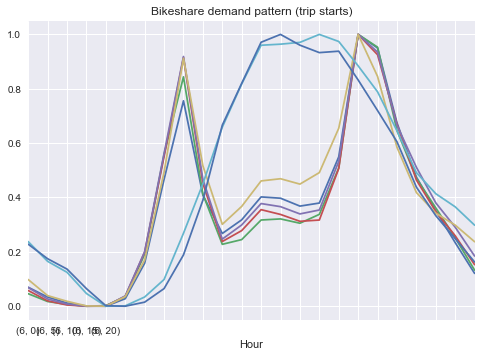

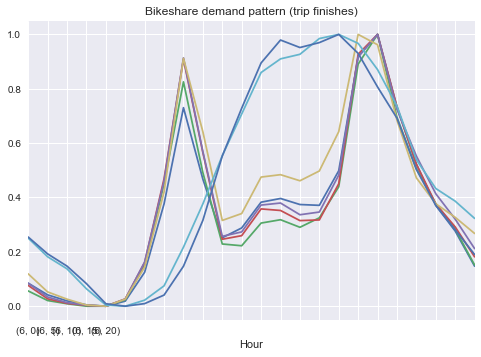

In [11]:
for idx,group in df_hourly_start.groupby(['dayofweek']):
    group.drop('workday',axis=1).groupby(['dayofweek','hourofday']).sum().apply(norm)['sum_all'].plot()

#.sum()['sum_all'].plot()
plt.title('Bikeshare demand pattern (trip starts)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

for idx,group in df_hourly_end.groupby(['dayofweek']):
    group.drop('workday',axis=1).groupby(['dayofweek','hourofday']).sum().apply(norm)['sum_all'].plot()

#.sum()['sum_all'].plot()
plt.title('Bikeshare demand pattern (trip finishes)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

When visualizing between the trip start and trip finish stats, there is an associated time lag between the trip start and finish. It is noticeably larger on non-workdays, as it appears more casual trips take place during those days.

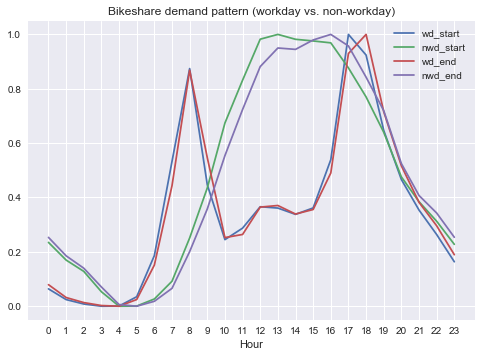

In [12]:
plt.figure()
plt.plot(df_hourly_start[df_hourly_start['workday']==1].groupby('hourofday')[['sum_all']].sum().apply(norm),label='wd_start')
plt.plot(df_hourly_start[df_hourly_start['workday']==0].groupby('hourofday')[['sum_all']].sum().apply(norm),label='nwd_start')
plt.plot(df_hourly_end[df_hourly_end['workday']==1].groupby('hourofday')[['sum_all']].sum().apply(norm),label='wd_end')
plt.plot(df_hourly_end[df_hourly_end['workday']==0].groupby('hourofday')[['sum_all']].sum().apply(norm),label='nwd_end')
plt.legend()
plt.title('Bikeshare demand pattern (workday vs. non-workday)')
plt.xticks(np.arange(0,24))
plt.xlabel('Hour')
plt.show()

In [26]:
df_site_nums = pd.DataFrame(columns=['site','site_start','count_in','count_out','count_net'])

for site in sites:
    site = int(site)
    site_start = df_hourly_start[site].dropna().index[0]
    count_out = df_hourly_start[site].sum()
    count_in = df_hourly_end[site].sum()
    count_net = count_in - count_out
    df_site_nums = df_site_nums.append({'site':site,'site_start':site_start,'count_in':count_in,'count_out':count_out,'count_net':count_net},ignore_index=True)

df_site_nums.set_index('site',inplace=True)

In [60]:
df_site_nums

,site_start,count_in,count_out,count_net
site,,,,
31000.0,2011-01-07 09:00:00,925.0,1171.0,-246.0
31001.0,2011-01-01 02:00:00,3495.0,3492.0,3.0
31002.0,2011-01-01 11:00:00,3407.0,2883.0,524.0
31003.0,2011-01-01 21:00:00,3532.0,3432.0,100.0
31004.0,2011-01-01 08:00:00,1644.0,1598.0,46.0
31005.0,2011-01-01 13:00:00,1732.0,1644.0,88.0
31006.0,2011-01-01 08:00:00,2760.0,2869.0,-109.0
31007.0,2011-01-01 00:00:00,8296.0,10089.0,-1793.0
31008.0,2011-01-01 15:00:00,2161.0,2023.0,138.0


In [65]:
#for site in sites:
#    for idx,group in df_hourly_start.groupby(['workday']):
#        df = group.fillna(0)
#        stats_mean = df.groupby(['workday','hourofday']).sum()
#        #print(stats)
#        
#        #stats_mean[site].plot(label=idx)
#        stats_mean.apply(norm)[site].plot(label=idx)
        
#    plt.title(site)
#    plt.legend()
#    plt.show()

#    for idx,group in df_hourly_end.groupby(['workday']):
#        df = group.fillna(0)
#        stats_mean = df.groupby(['workday','hourofday']).sum()
#        #print(stats)
#        #stats_mean[site].plot(label=idx)
#        stats_mean.apply(norm)[site].plot(label=idx)
#    plt.title(site)
#    plt.legend()
#    plt.show()

By taking the difference in counts between bike trips which end at a particular station and those that start at a particular station, we can see that a number of stations regularly gain bikes and lose bikes. While this is beyond the scope of the proposed anomaly detection, the anomaly detection algorithm will be able to advise unique situations where the demand is significantly accelerated or deccelerated for a particular time period (based on usage in the past 30 days).

This suggests that quite often, commuters may use the bikeshare in one direction only each day. From an earlier visualization, they are more likely to use the bike in the afternoon rush hour than in the morning, perhaps because the weather is generally warmer and it is easier to shower at home than at work.

In [61]:
print('Top 5 Bike Stations Gaining Bikes in 2011')
print((df_hourly_end.sum() - df_hourly_start.sum()).sort_values(ascending=False).nlargest(5))

Top 5 Bike Stations Gaining Bikes in 2011
31200    4817.0
31215    4725.0
31201    3754.0
31217    3482.0
31225    3457.0
dtype: float64


/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4488: RuntimeWarning: '>' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return_indexers=True)


In [62]:
print('Top 5 Bike Stations Losing Bikes in 2011')
print((df_hourly_end.sum() - df_hourly_start.sum()).sort_values(ascending=False).nsmallest(5))

Top 5 Bike Stations Losing Bikes in 2011
31103   -6730.0
31105   -4630.0
31104   -3716.0
31602   -3393.0
31102   -3341.0
dtype: float64


/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4488: RuntimeWarning: '>' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return_indexers=True)
